# Energy Demand Forecasting with Granite Timeseries (TTM)

Based on the [Granite-Timeseries-TTM](https://github.com/ibm-granite/granite-tsfm/blob/cookbook-dev/notebooks/recipes/energy_demand_forecasting/demand_forecast_zeroshot_recipe.ipynb) notebook.

### Install the TSFM Library 
NOTE: For Python 3.12 and above, you will need to install `setuptools`, which provides `distutils`.

In [2]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+ssh://git@github.com/ibm-granite/granite-tsfm.git@cookbook-dev"

# Install setuptools to get distutils.
! pip install setuptools

  Cloning ssh://****@github.com/ibm-granite/granite-tsfm.git (to revision cookbook-dev) to /private/var/folders/nc/jrql4k0n2j73h7xktzxdr4pr0000gn/T/pip-install-yzw4iudk/tsfm-public_333b80d8a9fc4603b1a443406b861ec3
  Running command git clone --filter=blob:none --quiet 'ssh://****@github.com/ibm-granite/granite-tsfm.git' /private/var/folders/nc/jrql4k0n2j73h7xktzxdr4pr0000gn/T/pip-install-yzw4iudk/tsfm-public_333b80d8a9fc4603b1a443406b861ec3
  Running command git checkout -b cookbook-dev --track origin/cookbook-dev
  Switched to a new branch 'cookbook-dev'
  Branch 'cookbook-dev' set up to track remote branch 'cookbook-dev' from 'origin'.
  Resolved ssh://****@github.com/ibm-granite/granite-tsfm.git to commit 07eb7f217bdc4ef08894cbc67c9efe42a745732b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pandas-2.2.2-cp312-cp312-macosx_10_9_x86_64.whl.metadata (19 kB)
  Using cached scikit_lear

### Import Packages

In [1]:
import tsfm_public
tsfm_public.__version__

ModuleNotFoundError: No module named 'tsfm_public'

In [14]:
import pandas as pd
import tempfile
import os

from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.visualization import plot_predictions

### Read in the Data

In [ ]:
DATA_ROOT_PATH = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv"
df_tmp = pd.read_csv(DATA_ROOT_PATH)


### Plot one of the Series

<Axes: xlabel='date'>

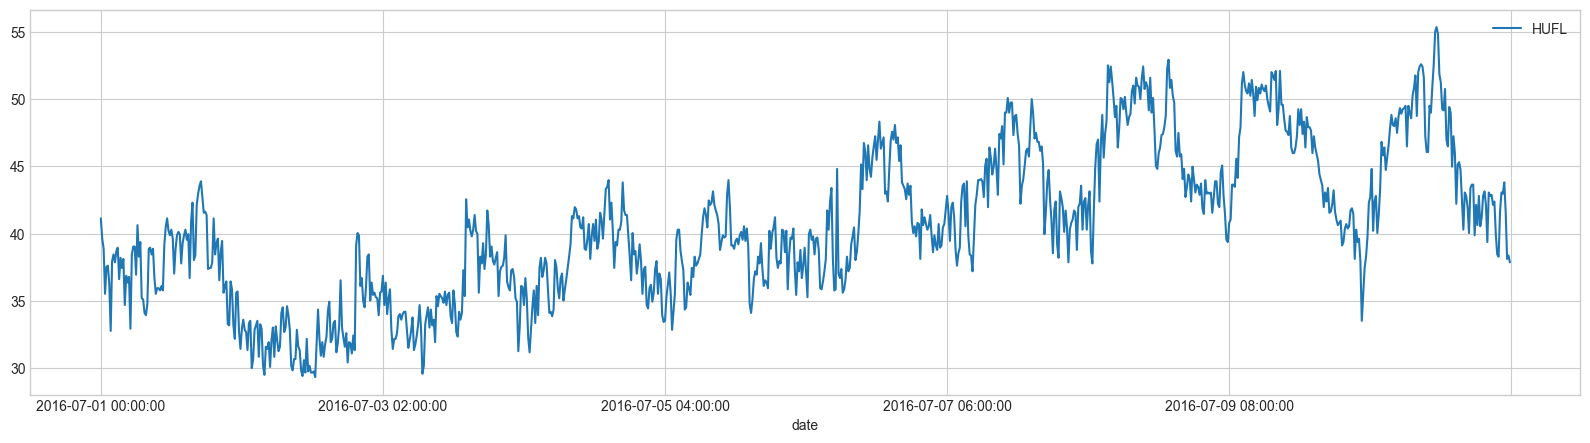

In [18]:
df_tmp.iloc[:1000].plot(x="date", y="HUFL", figsize=(20, 5))

### Get the test set for making predictions

In [11]:
# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

dataset_path = DATA_ROOT_PATH
timestamp_column = "date"
id_columns = []
target_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
split_config = {
    "train": [0, 12 * 30 * 24 * 4],
    "valid": [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4],
    "test": [
        12 * 30 * 24 * 4 + 4 * 30 * 24 * 4,
        12 * 30 * 24 * 4 + 8 * 30 * 24 * 4,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 1607, val = 11425, test = 11425


### Set up zero shot model

In [5]:
# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm-granite/granite-timeseries-ttm-v1", revision=TTM_MODEL_REVISION)

In [10]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    ),
)

### Evaluate the model

In [12]:
zeroshot_trainer.evaluate(test_dataset)

  0%|          | 0/179 [00:00<?, ?it/s]

{'eval_loss': 0.1860235035419464,
 'eval_model_preparation_time': 0.0013,
 'eval_runtime': 10.4839,
 'eval_samples_per_second': 1089.764,
 'eval_steps_per_second': 17.074}

### Make and plot predictions on the test set, along with the actuals

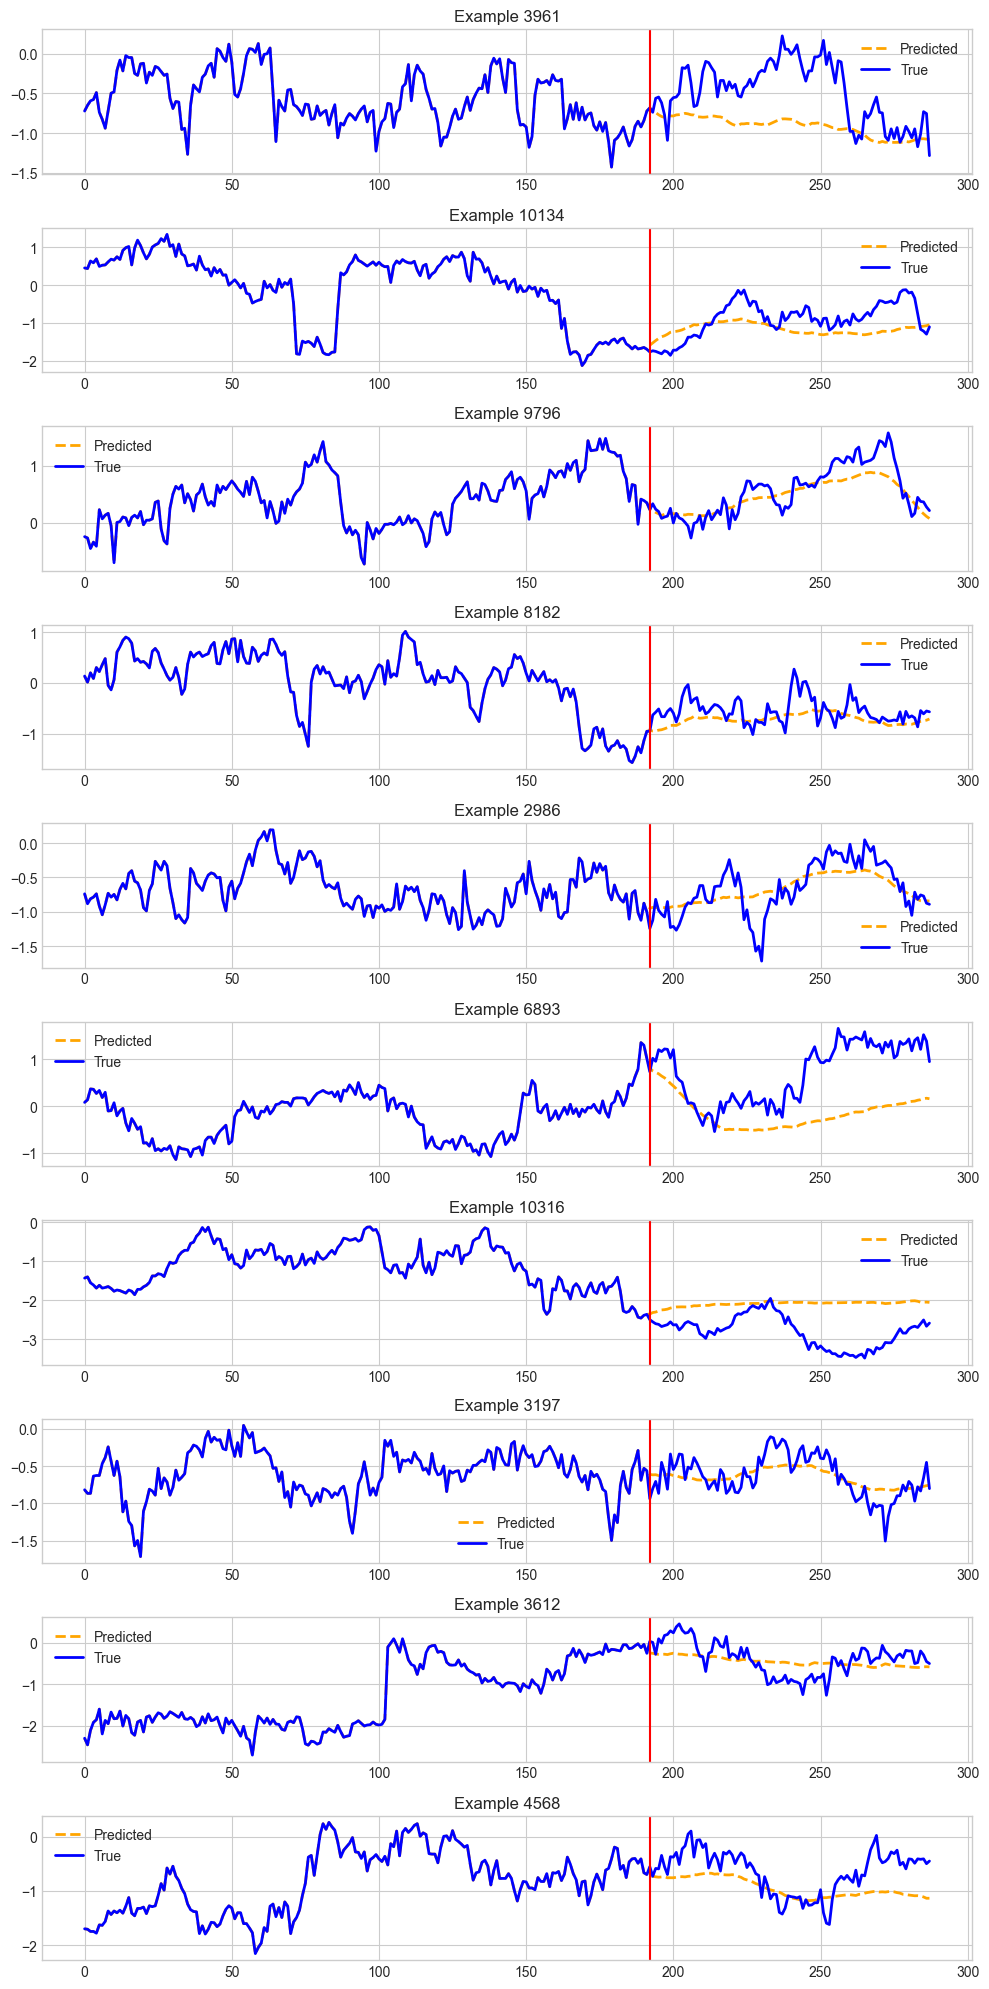

In [23]:
# plot
plot_predictions(
    model=zeroshot_model,
    dset=test_dataset,
    plot_dir=os.path.join(temp_dir, "plots"),
    plot_prefix="test_zeroshot",
    channel=0,
)